In [106]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

# Set up pytrends and define the keyword
pytrends = TrendReq(hl='en-US', tz=360)
keywords = ["gold etf"]


pytrends.build_payload(kw_list=keywords, timeframe='today 1-m', geo='')

# Fetch the interest over time for "gold"
gold_trends = pytrends.interest_over_time()


# Drop the 'isPartial' column if present
if 'isPartial' in gold_trends.columns:
    gold_trends = gold_trends.drop(columns=['isPartial'])

# View the first few rows
print(gold_trends.head())

            gold etf
date                
2024-10-13        24
2024-10-14        36
2024-10-15        32
2024-10-16        37
2024-10-17        44


/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


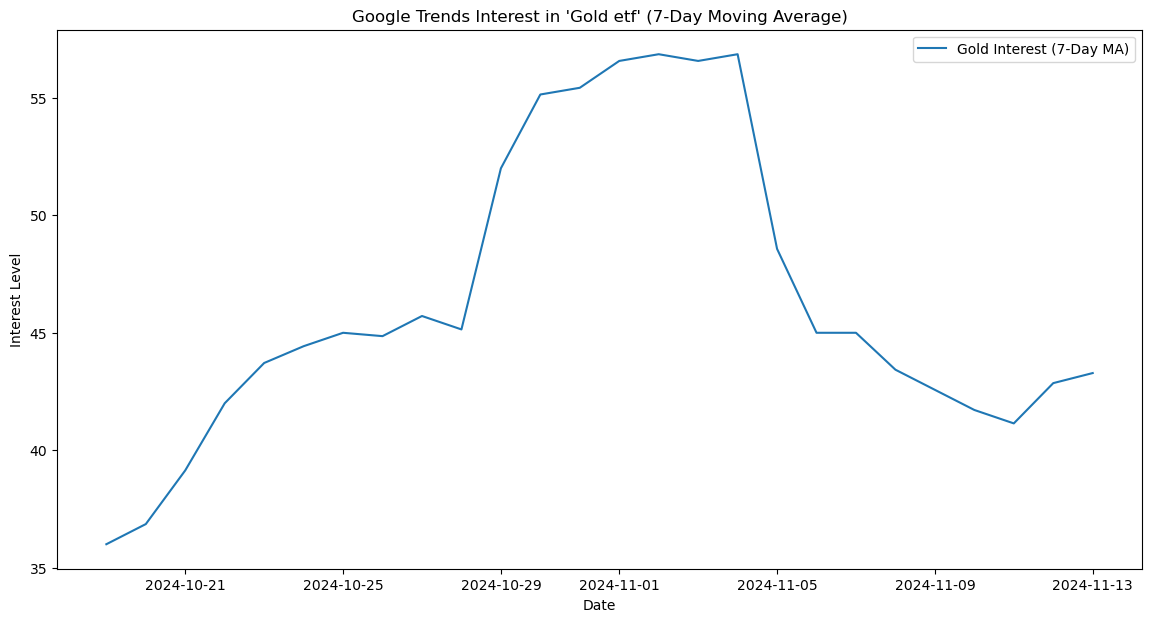

In [107]:
# Calculate a 7-day moving average to smooth the data
gold_trends['gold_ma'] = gold_trends['gold etf'].rolling(window=7).mean()

# Plot the moving average of the interest for visual inspection
plt.figure(figsize=(14, 7))
plt.plot(gold_trends['gold_ma'], label='Gold Interest (7-Day MA)')
plt.title("Google Trends Interest in 'Gold etf' (7-Day Moving Average)")
plt.xlabel("Date")
plt.ylabel("Interest Level")
plt.legend()
plt.show()


In [108]:
# Calculate momentum as the daily change in the 7-day moving average
gold_trends['momentum'] = gold_trends['gold_ma'].diff()

# Define buy/sell thresholds based on momentum
buy_threshold = 2  # Arbitrary threshold for a significant positive change
sell_threshold = -2  # Arbitrary threshold for a significant negative change

# Generate buy/sell signals based on momentum
gold_trends['signal'] = 0  # Default to hold
gold_trends['signal'][gold_trends['momentum'] > buy_threshold] = 1   # Buy signal
gold_trends['signal'][gold_trends['momentum'] < sell_threshold] = -1  # Sell signal

# Shift signals by 1 to avoid look-ahead bias (execute on the next day)
gold_trends['signal'] = gold_trends['signal'].shift(1)


/var/folders/2v/418w7x5d03g34d38xmfssx8h0000gn/T/ipykernel_68289/3858649478.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  gold_trends['signal'][gold_trends['momentum'] > buy_threshold] = 1   # Buy signal
/var/folders/2v/418w7x5d03g34d

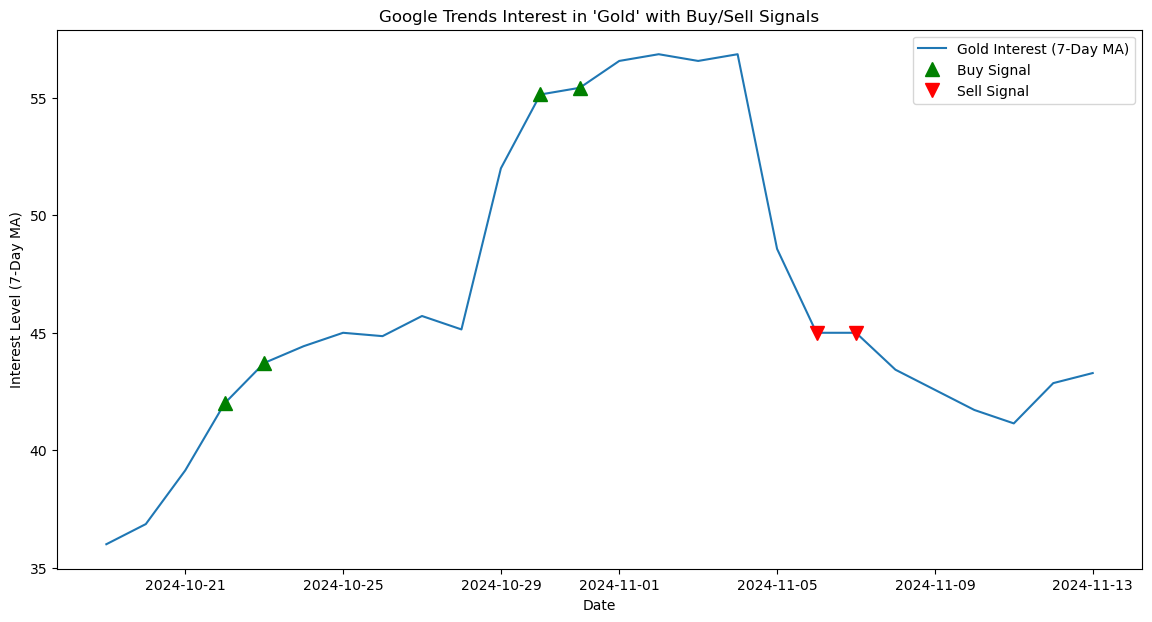

In [109]:
# Plot the trend data with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(gold_trends['gold_ma'], label="Gold Interest (7-Day MA)")
plt.plot(gold_trends[gold_trends['signal'] == 1].index, 
         gold_trends['gold_ma'][gold_trends['signal'] == 1], 
         '^', markersize=10, color='g', label='Buy Signal')
plt.plot(gold_trends[gold_trends['signal'] == -1].index, 
         gold_trends['gold_ma'][gold_trends['signal'] == -1], 
         'v', markersize=10, color='r', label='Sell Signal')
plt.title("Google Trends Interest in 'Gold' with Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Interest Level (7-Day MA)")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed

Price                        Adj Close        Close         High          Low  \
Ticker                            GC=F         GC=F         GC=F         GC=F   
Date                                                                            
2024-10-21 00:00:00+00:00  2723.100098  2723.100098  2738.399902  2719.500000   
2024-10-22 00:00:00+00:00  2744.199951  2744.199951  2746.000000  2728.600098   
2024-10-23 00:00:00+00:00  2714.399902  2714.399902  2742.500000  2714.199951   
2024-10-24 00:00:00+00:00  2734.899902  2734.899902  2736.100098  2729.000000   
2024-10-25 00:00:00+00:00  2740.899902  2740.899902  2742.399902  2725.500000   

Price                             Open Volume  
Ticker                            GC=F   GC=F  
Date                                           
2024-10-21 00:00:00+00:00  2721.899902     52  
2024-10-22 00:00:00+00:00  2731.699951     93  
2024-10-23 00:00:00+00:00  2742.500000     18  
2024-10-24 00:00:00+00:00  2729.000000     27  
2024-10-25 00:0

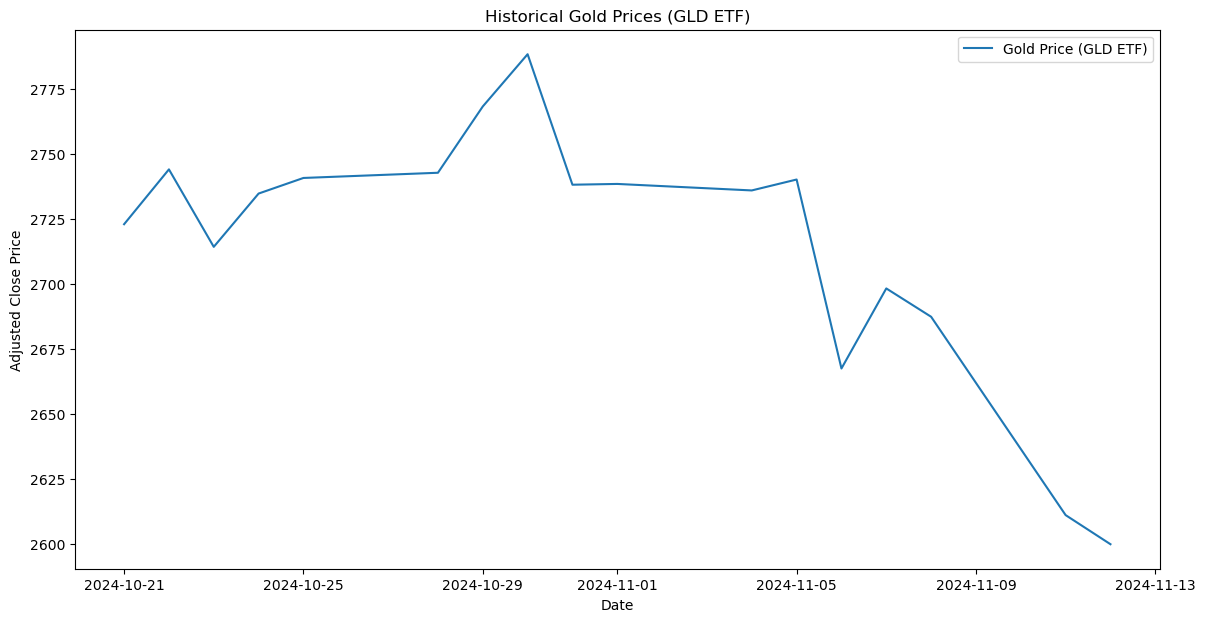

In [115]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol for the gold ETF
gold_etf = "GC=F"

# Fetch historical prices for GLD
gold_prices = yf.download(gold_etf, start="2024-10-21", end="2024-11-13")

# Display the first few rows
print(gold_prices.head())

# Use the 'Adj Close' column to represent gold prices
gold_prices['Returns'] = gold_prices['Adj Close'].pct_change()

# Plot the gold prices
plt.figure(figsize=(14, 7))
plt.plot(gold_prices['Adj Close'], label='Gold Price (GLD ETF)')
plt.title("Historical Gold Prices (GLD ETF)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()


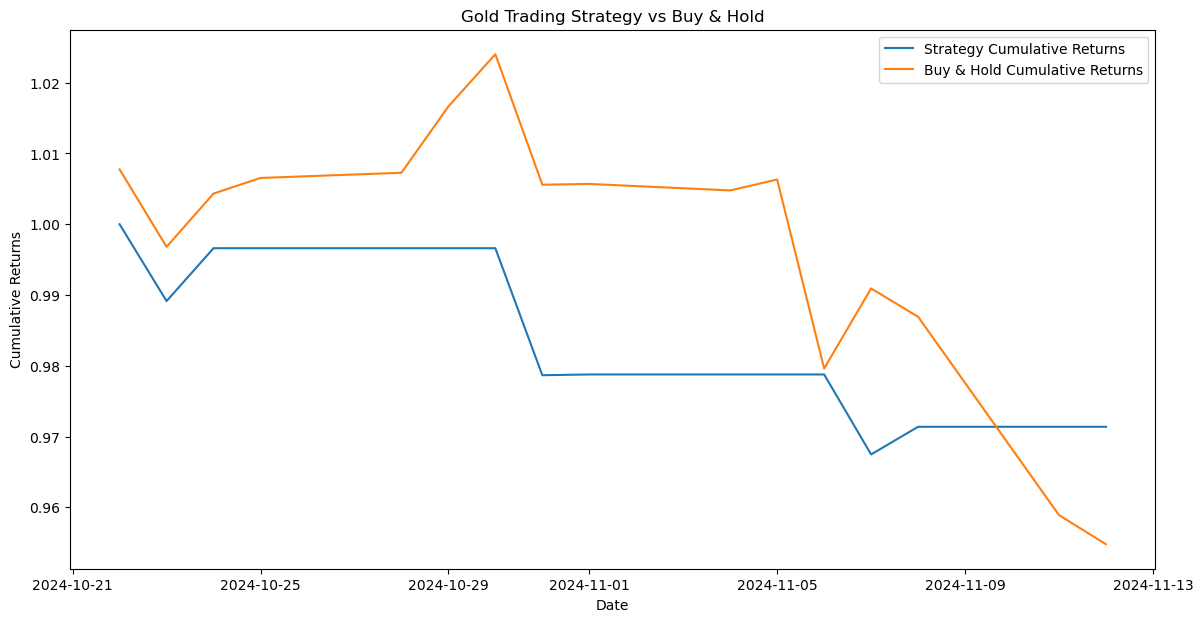

In [116]:
# Assume 'gold_trends' DataFrame already contains the buy/sell signals in the 'signal' column
# Remove timezone information from both DataFrames to ensure compatibility
gold_prices.index = gold_prices.index.tz_localize(None)
gold_trends.index = gold_trends.index.tz_localize(None)


gold_prices['signal'] = gold_trends['signal'].reindex(gold_prices.index, method='ffill').fillna(0)

# Calculate strategy returns based on the signals
gold_prices['Strategy Returns'] = gold_prices['Returns'] * gold_prices['signal'].shift(1)

# Calculate cumulative returns
gold_prices['Cumulative Strategy Returns'] = (1 + gold_prices['Strategy Returns']).cumprod()
gold_prices['Cumulative Buy & Hold Returns'] = (1 + gold_prices['Returns']).cumprod()

# Plot cumulative returns for strategy vs. buy & hold
plt.figure(figsize=(14, 7))
plt.plot(gold_prices['Cumulative Strategy Returns'], label='Strategy Cumulative Returns')
plt.plot(gold_prices['Cumulative Buy & Hold Returns'], label='Buy & Hold Cumulative Returns')
plt.title("Gold Trading Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()
